# Bayesian Estimation of Position and Velocity

This notebook demonstrates how to estimate the position and velocity of an object using Bayesian inference with the `emcee` library.

In [20]:
# Install the necessary libraries
# emcee: for MCMC sampling
# corner: for visualizing the posterior distributions
!pip install emcee corner

In [21]:
# Import the necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import emcee
import corner

## Position Estimation

In [22]:
# Position Estimation

# Load the data from the specified path
pathfile = '/content/drive/MyDrive/Work/Research/Bayes_PINN/bayesian-ml-physics-lab/data/U1.txt'
data = np.loadtxt(pathfile)

# Define the model function for the position
# This is a sinusoidal function with an exponential decay
def model(x, a, b, c, d, e):
    return a * np.exp(-b * x) * np.sin(c * x + d) + e

# Define the log prior function
# This function defines the prior probability distribution for each parameter
# We use uniform priors within specified ranges
def log_prior(params):
    a, b, c, d, e = params
    if 0.01 < a < 1 and 0.01 < b < 11 and 5 < c < 15 and -10 < d < -5 and -1 < e < -0.001:
        return 0.0  # Log of probability 1 is 0
    return -np.inf  # Log of probability 0 is -infinity

# Define the log probability function
# This function combines the log prior and the log likelihood
def log_probability(params, x, y, yerr):
    # Calculate the log prior
    prior = log_prior(params)
    # If the prior is not finite, the log probability is also not finite
    if not np.isfinite(prior):
        return -np.inf

    # Calculate the model prediction for the given parameters
    y_model = model(x, *params)
    # Calculate the chi-squared value
    chi_squared = np.sum(((y - y_model) / yerr) ** 2)
    # Calculate the log likelihood
    log_likelihood = -0.5 * chi_squared

    # Return the sum of the log prior and log likelihood
    return prior + log_likelihood

# Observed data for position
xdata_pos = data[:, 0]  # Time data
ydata_pos = data[:, 1]  # Position data
yerr = 0.001  # Error in the position data

# Initial guess for the model parameters
initial_guess = [0.02, 0.5, 10.0, -7.0, -0.003]

# Set the number of walkers and dimensions for the MCMC
nwalkers = 700
ndim = len(initial_guess)

# Generate an initial random sample of parameters for the walkers
pos = initial_guess + 1e-4 * np.random.randn(nwalkers, ndim)

# Create the EnsembleSampler object from emcee
# This object will run the MCMC sampling
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(xdata_pos, ydata_pos, yerr), moves=emcee.moves.StretchMove(a=0.1))

# Run the MCMC for a "burn-in" phase to let the walkers settle
n_burnin_steps = 500
pos, _, _ = sampler.run_mcmc(pos, n_burnin_steps)

# Reset the sampler to clear the burn-in samples
sampler.reset()

# Run the main MCMC sampling
n_steps = 10000
sampler.run_mcmc(pos, n_steps, progress=True)

# Get the chains of samples generated by the sampling
samples = sampler.get_chain()

# Flatten the samples, discarding the first 100 as a final burn-in and thinning by 15
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

# Display the fitted parameter values and their uncertainties
fitted_parameters = []
for i in range(ndim):
    # Calculate the 16th, 50th, and 84th percentiles of the samples for each parameter
    mcmc_result = np.percentile(flat_samples[:, i], [16, 50, 84])
    # The 50th percentile is the median, which we take as the fitted value
    fitted_parameters.append(mcmc_result[1])
    # Print the fitted value and the uncertainties
    print(f"Parameter {i+1}: {mcmc_result[1]:.2e} +{mcmc_result[2]-mcmc_result[1]:.2e} -{mcmc_result[1]-mcmc_result[0]:.2e}")

# Print the list of fitted parameters
print(fitted_parameters)
# Unpack the fitted parameters for later use
pu, pd, pt, pc, pci = fitted_parameters

100%|██████████| 10000/10000 [03:17<00:00, 50.61it/s]


Parameter 1: 2.71e-02 +4.12e-04 -4.09e-04
Parameter 2: 5.64e-01 +1.10e-02 -1.08e-02
Parameter 3: 1.06e+01 +1.31e-02 -1.30e-02
Parameter 4: -7.45e+00 +1.54e-02 -1.54e-02
Parameter 5: -3.61e-03 +6.61e-05 -6.64e-05
[np.float64(0.027104444376854067), np.float64(0.5639785917984181), np.float64(10.553133019369422), np.float64(-7.452819106142245), np.float64(-0.0036121423060258145)]


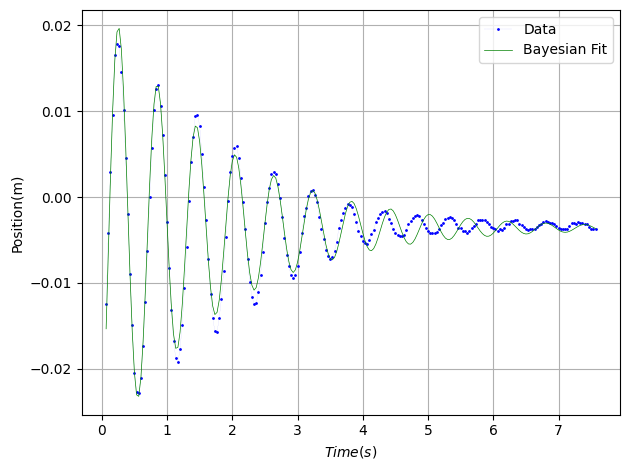

In [23]:
# Plot the data and the Bayesian fit for position

# Calculate the theoretical position using the fitted parameters
ytheo_pos = pu * np.exp(-pd * xdata_pos) * np.sin(pt * xdata_pos + pc) + pci

# Create the plot
plt.plot(xdata_pos, ydata_pos, color='blue', label='Data', marker='.', markersize=2.0, linewidth=0.05, ls='--')
plt.plot(xdata_pos, ytheo_pos, color='green', linewidth=0.5, label='Bayesian Fit')

# Set the labels and title
plt.xlabel(r'$Time (s)$')
plt.ylabel(r'Position(m)')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

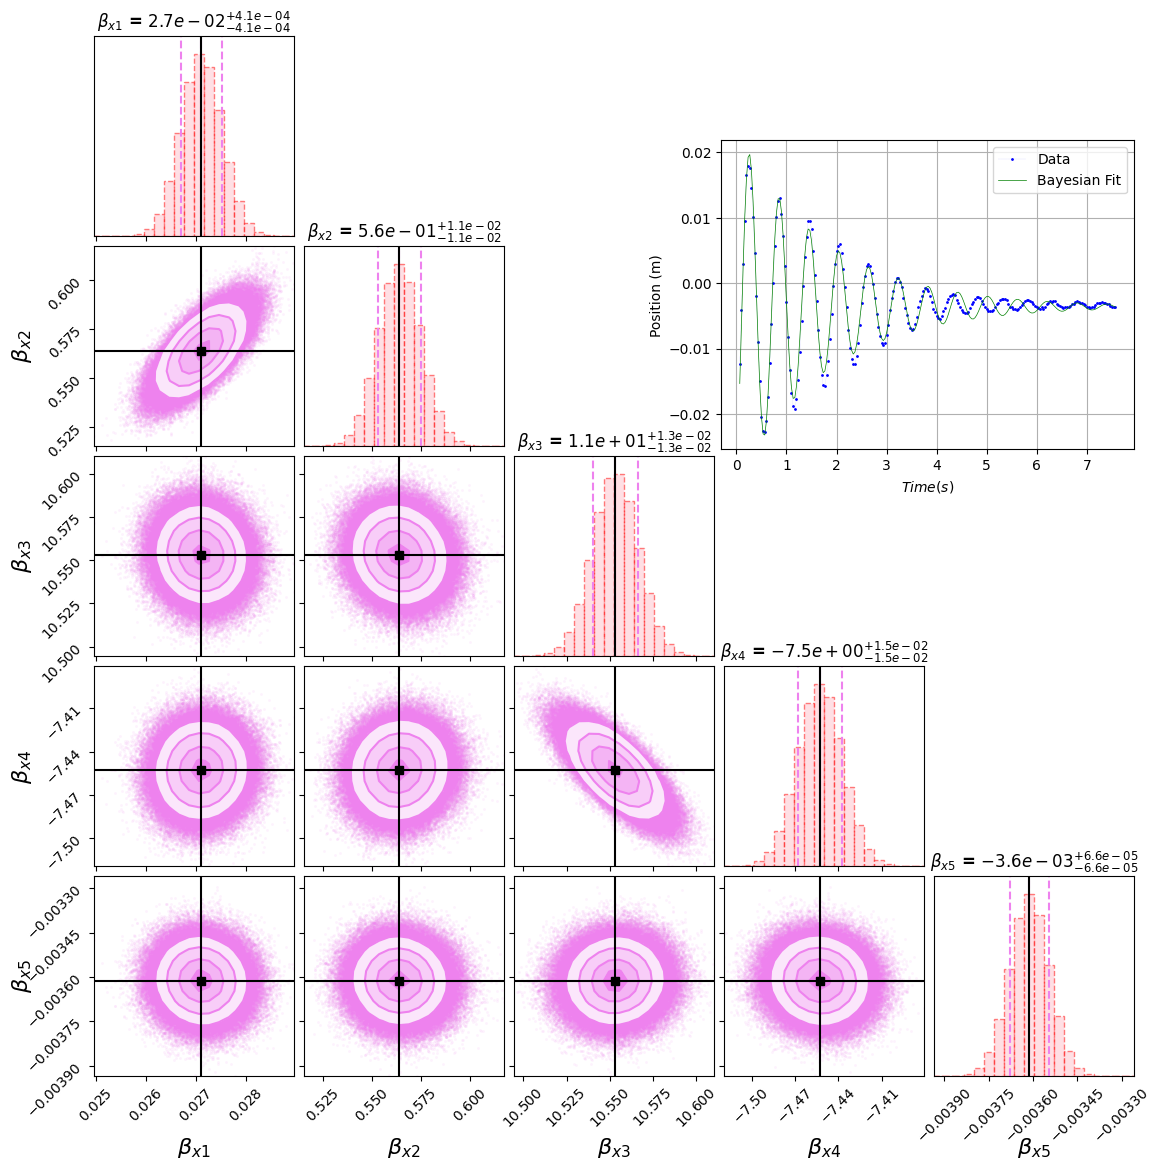

In [24]:
# Create a corner plot to visualize the posterior distributions of the position parameters

# Get the median of the fitted parameters
medians = np.array(fitted_parameters)
medians_list = medians.tolist()

# Define the labels for the parameters
labels = [r'$\beta_{x1}$', r'$\beta_{x2}$', r'$\beta_{x3}$', r'$\beta_{x4}$',r'$\beta_{x5}$']
label_kwargs = {"fontsize": 16, "color": "black", "fontweight": "bold"}

# Create the corner plot
fig = corner.corner(flat_samples, labels=labels, quantiles=[0.16, 0.5, 0.84],
    color="violet",
    show_titles=True,
    add_pvalue=True,
    plot_density=True,
    plot_contours=True,
    smooth=1.0,
    max_n_ticks=5,
    use_math_text=True,
    fill_contours=True,
    truths= medians_list,
    truth_color="black",
    title_fmt='.1e',
    color_hist="violet",color_dens="green",
    group="posterior",
    label_kwargs=label_kwargs,
    hist_kwargs={"color": "pink","edgecolor": "red","linestyle":"dashed", "linewidth": 1,"alpha": 0.5,"histtype":"barstacked"},
    title_kwargs={"fontsize": 12,"color": "Black", "fontweight": "bold"})

# Add an inset plot showing the data and the fit
ax = plt.subplot2grid((10, 10), (1, 6), rowspan=3, colspan=4)
ax.plot(x_data, y_data, color='blue', label='Data', marker='.', markersize=2.0, linewidth=0.05, ls='--')
ax.plot(x_data, y_theo, color='green', linewidth=0.5, label='Bayesian Fit')
ax.set_xlabel(r'$Time (s)$')
ax.set_ylabel(r'Position (m)')
ax.legend()
ax.grid(True)

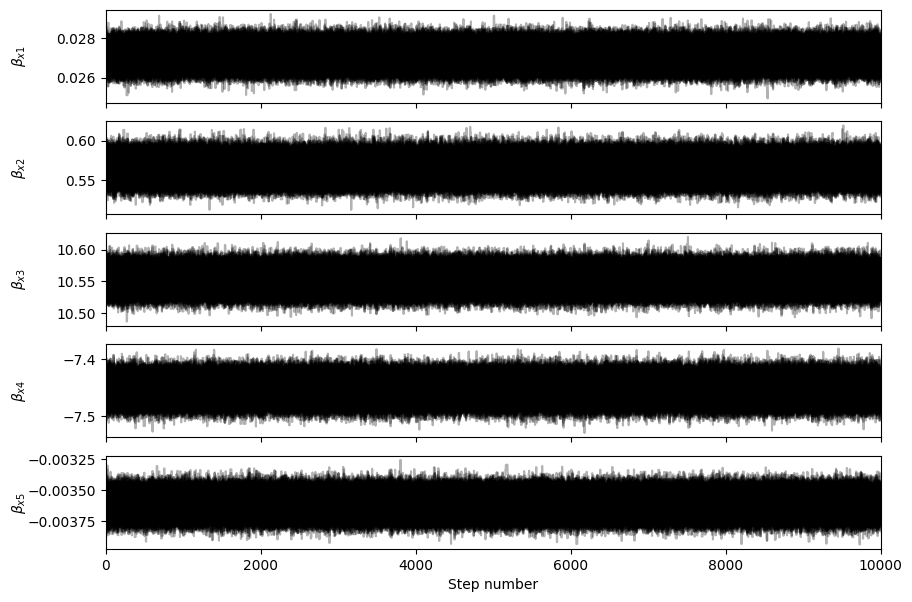

In [25]:
# Create a trace plot to diagnose the convergence of the MCMC chains for the position parameters

# Create a figure with subplots for each parameter
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
labels = [r'$\beta_{x1}$', r'$\beta_{x2}$', r'$\beta_{x3}$', r'$\beta_{x4}$', r'$\beta_{x5}$']

# Plot the samples for each walker over the steps
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

# Set the x-label for the last subplot
axes[-1].set_xlabel("Step number")

# Show the plot
plt.show()

## Velocity Estimation

In [26]:
# Velocity Estimation

# Load the data (can be reused from the position estimation)
data_vel = np.loadtxt('/content/drive/MyDrive/Work/Research/Bayes_PINN/bayesian-ml-physics-lab/data/U1.txt')

# Define the model function for velocity
# This is the derivative of the position model
def vel_model(x, k, l, m, n):
    """A model for velocity."""
    return k * np.exp(-l * x) * (m * np.cos(m * x + n) - l * np.sin(m * x + n))

# Define the log prior function for velocity parameters
def log_prior_vel(params):
    """
    Log of the prior probability distribution for velocity parameters.
    Defines uniform priors for each parameter in specific ranges.
    """
    k, l, m, n = params
    # We use the information from the position estimation to set the priors
    # For example, the prior for 'l' is centered around the fitted value 'pd'
    if pu*0.9 < k < pu*1.1 and pd*0.9 < l < pd*1.1 and pt*0.9 < m < pt*1.1 and pc*0.9 < n < pc*1.1:
        return 0.0
    return -np.inf

# Define the log probability function for velocity
def log_probability_vel(params, x, y, yerr):
    """
    Log of the posterior probability distribution for velocity.
    Combines the prior and the likelihood.
    """
    prior = log_prior_vel(params)
    if not np.isfinite(prior):
        return -np.inf

    y_model = vel_model(x, *params)
    chi_squared = np.sum(((y - y_model) / yerr) ** 2)
    log_likelihood = -0.5 * chi_squared

    return prior + log_likelihood

# Observed data for velocity
xdata_vel = data_vel[:, 0]  # Time data
ydata_vel = data_vel[:, 2]  # Velocity data
yerr_vel = 0.001  # Error in the velocity data

# Initial guess for the velocity model parameters, informed by the position fit
initial_guess_vel = [pu, pd, pt, pc]

# Set the number of walkers and dimensions for the MCMC
nwalkers_vel = 700
ndim_vel = len(initial_guess_vel)

# Generate an initial random sample of parameters for the walkers
pos_vel = initial_guess_vel + 1e-4 * np.random.randn(nwalkers_vel, ndim_vel)

# Create the sampler object for velocity
sampler_vel = emcee.EnsembleSampler(nwalkers_vel, ndim_vel, log_probability_vel, args=(xdata_vel, ydata_vel, yerr_vel), moves=emcee.moves.StretchMove(a=0.1))

# Run MCMC for the burn-in phase
sampler_vel.run_mcmc(pos_vel, n_burnin_steps)

# Reset the chains for the post-burn-in sampling phase
sampler_vel.reset()

# Run the main MCMC sampling for velocity
sampler_vel.run_mcmc(pos_vel, n_steps, progress=True)

# Get the chains of samples
samples_vel = sampler_vel.get_chain()

# Flatten the samples, discarding burn-in and thinning
flat_samples_vel = sampler_vel.get_chain(discard=100, thin=15, flat=True)

# Display the fitted parameter values for velocity
fitted_parameters_vel = []
for i in range(ndim_vel):
    mcmc_result = np.percentile(flat_samples_vel[:, i], [16, 50, 84])
    fitted_parameters_vel.append(mcmc_result[1])
    q = np.diff(mcmc_result)
    print(f"Velocity Parameter {i+1}: {mcmc_result[1]:.2e} (+{q[1]:.2e}) (-{q[0]:.2e})")

# Print the list of fitted velocity parameters
print("Fitted velocity parameters:", fitted_parameters_vel)
# Unpack the fitted velocity parameters
K, L, M, N = fitted_parameters_vel

/usr/local/lib/python3.11/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [00:56<00:00, 178.12it/s]

Velocity Parameter 1: 2.71e-02 (+9.03e-05) (-1.01e-04)
Velocity Parameter 2: 5.64e-01 (+9.87e-05) (-1.02e-04)
Velocity Parameter 3: 1.06e+01 (+1.01e-04) (-1.01e-04)
Velocity Parameter 4: -7.45e+00 (+9.08e-05) (-9.96e-05)
Fitted velocity parameters: [np.float64(0.02710924686243267), np.float64(0.5639767350347977), np.float64(10.553131806742883), np.float64(-7.452816495512314)]


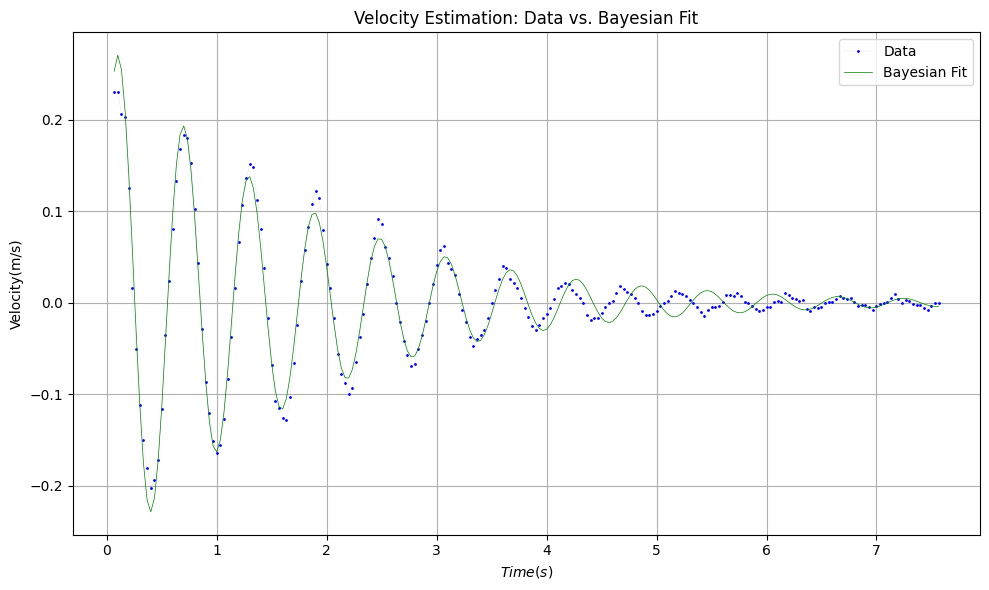

In [27]:
# Plot the observed velocity data versus the Bayesian fit

# Get the median of the fitted parameters
medians = np.array(fitted_parameters_vel)
medians_list = medians.tolist()

# Calculate the theoretical velocity using the fitted parameters
ytheo_vel = vel_model(xdata_vel, *fitted_parameters_vel)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(xdata_vel, ydata_vel, color='blue', label='Data', marker='.', markersize=2.0, linewidth=0.05, ls='--')
plt.plot(xdata_vel, ytheo_vel, color='green', linewidth=0.5, label='Bayesian Fit')

# Set the labels and title
plt.xlabel(r'$Time (s)$')
plt.ylabel(r'Velocity(m/s)')
plt.title('Velocity Estimation: Data vs. Bayesian Fit')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

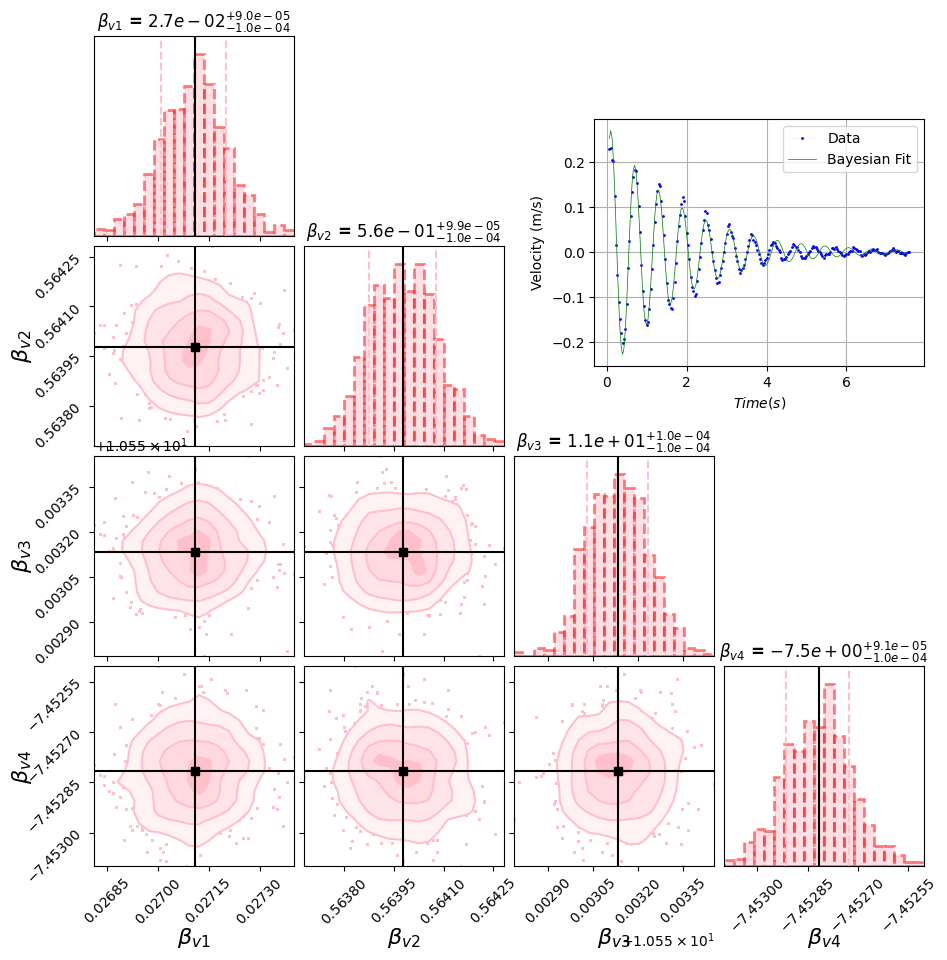

In [28]:
# Visualize the posterior distributions for velocity parameters using a corner plot

# Define the labels for the velocity parameters
labels_vel = [r'$\beta_{v1}$', r'$\beta_{v2}$', r'$\beta_{v3}$', r'$\beta_{v4}$']

# Create the corner plot
fig_vel = corner.corner(flat_samples_vel, labels=labels_vel, quantiles=[0.16, 0.5, 0.84],
    color="pink",
    show_titles=True,
    add_pvalue=True,
    plot_density=True,
    plot_contours=True,
    smooth=1.0,
    max_n_ticks=5,
    use_math_text=True,
    fill_contours=True,
    truths= medians_list,
    truth_color="black",
    title_fmt='.1e',
    color_hist="violet", color_dens="green",
    group="posterior",
    label_kwargs=label_kwargs,
    hist_kwargs={"color": "pink","edgecolor": "red","linestyle":"dashed", "linewidth": 2,"alpha": 0.5,"histtype":"barstacked"},
    title_kwargs={"fontsize": 12,"color": "Black", "fontweight": "bold"})

# Add an inset plot showing the velocity data and the fit
ax = plt.subplot2grid((10, 10), (1, 6), rowspan=3, colspan=4)
ax.plot(xdata_vel, ydata_vel, color='blue', label='Data', marker='.', markersize=2.0, linewidth=0.05, ls='--')
ax.plot(xdata_vel, ytheo_vel, color='green', linewidth=0.5, label='Bayesian Fit')
ax.set_xlabel(r'$Time (s)$')
ax.set_ylabel(r'Velocity (m/s)')
ax.legend()
ax.grid(True)

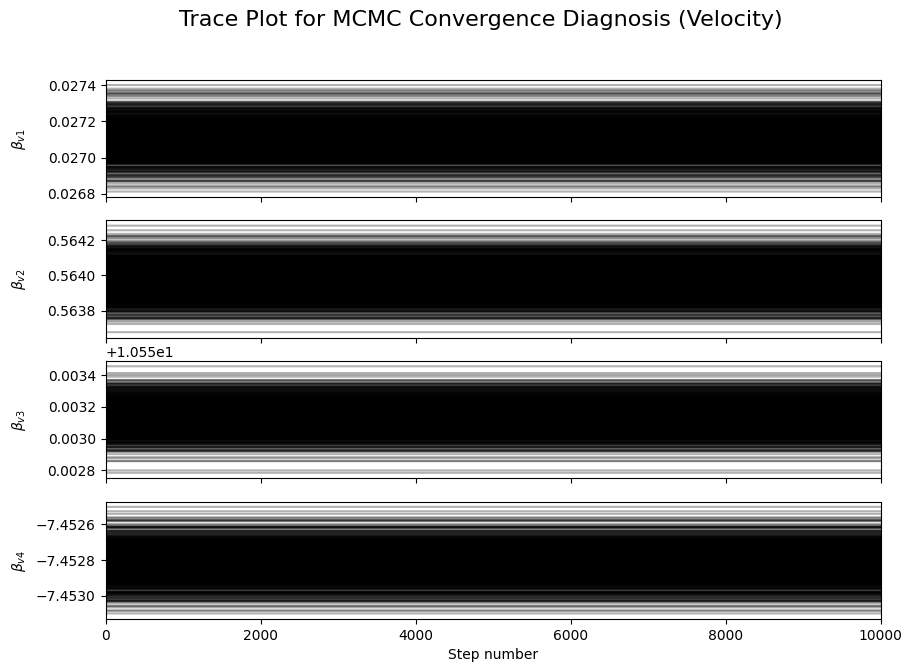

In [29]:
# Diagnose the convergence of the MCMC chains for velocity using a trace plot

# Create a figure with subplots for each velocity parameter
fig_vel, axes_vel = plt.subplots(ndim_vel, figsize=(10, 7), sharex=True)

# Plot the samples for each walker over the steps
for i in range(ndim_vel):
    ax = axes_vel[i]
    ax.plot(samples_vel[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_vel))
    ax.set_ylabel(labels_vel[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

# Set the x-label for the last subplot
axes_vel[-1].set_xlabel("Step number")
# Add a title to the plot
plt.suptitle('Trace Plot for MCMC Convergence Diagnosis (Velocity)', fontsize=16)

# Show the plot
plt.show()